https://www.depends-on-the-definition.com/guide-to-word-vectors-with-gensim-and-keras/

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
path = '../data/toxic_tut/'

TRAIN_DATA_FILE = path + 'train.csv'
TEST_DATA_FILE = path + 'test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

In [4]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

Processing text dataset


100%|██████████| 312735/312735 [00:23<00:00, 13217.89it/s]


In [5]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 365516 unique tokens


In [6]:
from gensim.models import Word2Vec

In [7]:
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=16, sg=0, negative=5)

In [8]:
word_vectors = model.wv

In [9]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 70056


In [10]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('princess', 0.9750618934631348),
 ('prince', 0.9707062840461731),
 ('bishop', 0.9687682390213013),
 ('mary', 0.9498376846313477),
 ('queen', 0.9489781856536865),
 ('duchess', 0.9352371692657471),
 ('pope', 0.9326463341712952),
 ('saint', 0.9289510846138),
 ('emperor', 0.9274678826332092),
 ('roosevelt', 0.9241782426834106)]

In [11]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [12]:
from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 200)


In [14]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

In [21]:
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [16]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

In [17]:
# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [18]:
embedded_sequences = wv_layer(comment_input)

In [22]:
# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

In [23]:
# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

In [24]:
# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          7005600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
__________

In [35]:
hist = model.fit(data, y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 517s 4ms/step - loss: 0.0613 - val_loss: 0.0525


In [39]:
score = model.evaluate(data, y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

IndexError: invalid index to scalar variable.

In [38]:
history.head()

,val_loss,loss
0,0.055682,0.070012


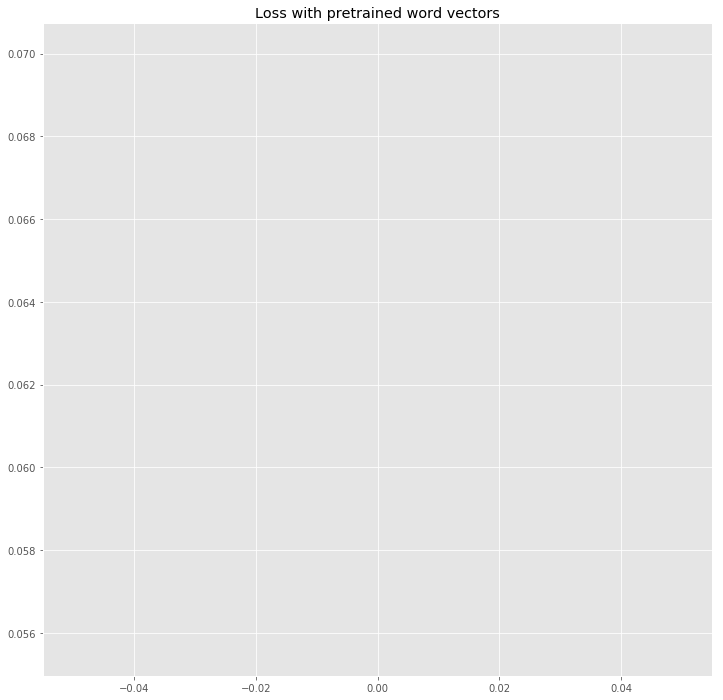

In [32]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [ ]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with random word vectors");
plt.show();